# Progetto Big Data (PySpark) - Unipa

Per una descrizione più completa sui vari passaggi, si faccia riferimento al notebook `Progetto Big Data (Sklearn) - Unipa`.

## Import

In [1]:
import pandas as pd
import re
from pyspark.sql import SparkSession, functions as f, dataframe
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.feature import UnivariateFeatureSelector
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
import numpy as np
from pyspark.ml import Pipeline

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_context("paper")

## Data Load

In [2]:
spark = SparkSession.builder.appName('Progetto Big Data - Unipa').getOrCreate()

csv_file = "../data/creditcard.csv"
df = spark.read.format("csv").option("inferSchema", "true").option("header", "true").load(csv_file)
 
print(df)
df.head()

21/08/30 10:04:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/08/30 10:04:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[Time: double, V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double, V17: double, V18: double, V19: double, V20: double, V21: double, V22: double, V23: double, V24: double, V25: double, V26: double, V27: double, V28: double, Amount: double, Class: int]


Row(Time=0.0, V1=-1.3598071336738, V2=-0.0727811733098497, V3=2.53634673796914, V4=1.37815522427443, V5=-0.338320769942518, V6=0.462387777762292, V7=0.239598554061257, V8=0.0986979012610507, V9=0.363786969611213, V10=0.0907941719789316, V11=-0.551599533260813, V12=-0.617800855762348, V13=-0.991389847235408, V14=-0.311169353699879, V15=1.46817697209427, V16=-0.470400525259478, V17=0.207971241929242, V18=0.0257905801985591, V19=0.403992960255733, V20=0.251412098239705, V21=-0.018306777944153, V22=0.277837575558899, V23=-0.110473910188767, V24=0.0669280749146731, V25=0.128539358273528, V26=-0.189114843888824, V27=0.133558376740387, V28=-0.0210530534538215, Amount=149.62, Class=0)

In [3]:
distribuzione_classi = df.groupBy('Class').count().toPandas().eval("relative_freq = count / count.sum()")
print(distribuzione_classi)

   Class   count  relative_freq
0      1     492       0.001727
1      0  284315       0.998273


Le Feature `V*` hanno una media uguale a zero (prevedibile dato che derivano da una PCA) e Deviazione Standard contenuta.

In [4]:
def describe(df):
    descriptive_stats = df.describe().toPandas().set_index("summary").T
    descriptive_stats.loc[:, ["mean", "stddev", "min", "max"]] = descriptive_stats.loc[:, ["mean", "stddev", "min", "max"]].astype("float").round(2)
    return descriptive_stats
    
describe(df)

summary,count,mean,stddev,min,max
Time,284807,94813.86,47488.15,0.0,172792.0
V1,284807,0.0,1.96,-56.41,2.45
V2,284807,0.0,1.65,-72.72,22.06
V3,284807,-0.0,1.52,-48.33,9.38
V4,284807,0.0,1.42,-5.68,16.88
V5,284807,0.0,1.38,-113.74,34.8
V6,284807,0.0,1.33,-26.16,73.3
V7,284807,-0.0,1.24,-43.56,120.59
V8,284807,0.0,1.19,-73.22,20.01
V9,284807,-0.0,1.1,-13.43,15.59


In [5]:
# subsample = df.sample(withReplacement=False, fraction=5000 / df.count(), seed=42).toPandas()
# profile = ProfileReport(subsample, title="Profiling Report", minimal=True)
# with open("progetto-big-data-unipa-spark-1-profile.html", "w") as out:
#     out.write(profile.to_html())

In [6]:
# # Calcolo il peso da assegnare alle classi come l'inverso della frequenza relativa
rel_freqs = df.groupBy('Class').count().toPandas()\
    .eval("relative_freq = count / count.sum()")\
    .eval("Peso = 1 - relative_freq")
print(rel_freqs, end="\n\n")

pesi = rel_freqs.set_index("Class")["Peso"]
print(pesi, end="\n\n")

fraud_weight = pesi[1]
regular_weight = pesi[0]
print(f"weights: FRAUD={fraud_weight}; REGULAR={regular_weight}", end="\n\n")


# Attribuiamo la colonna Peso nei dataset di train e test
df = df.withColumn("Peso", f.when(f.col("Class") == 1, fraud_weight).otherwise(regular_weight))

# Check everything seems ok
print(df.select('Class', 'Peso').where(f.col('Class')==1).show(3))
print(df.select('Class', 'Peso').where(f.col('Class')==0).show(3))

   Class   count  relative_freq      Peso
0      1     492       0.001727  0.998273
1      0  284315       0.998273  0.001727

Class
1    0.998273
0    0.001727
Name: Peso, dtype: float64

weights: FRAUD=0.9982725143693799; REGULAR=0.0017274856306199737

+-----+------------------+
|Class|              Peso|
+-----+------------------+
|    1|0.9982725143693799|
|    1|0.9982725143693799|
|    1|0.9982725143693799|
+-----+------------------+
only showing top 3 rows

None
+-----+--------------------+
|Class|                Peso|
+-----+--------------------+
|    0|0.001727485630619...|
|    0|0.001727485630619...|
|    0|0.001727485630619...|
+-----+--------------------+
only showing top 3 rows

None


## Creazione dei dataset train e test

In [7]:
def print_class_distr(df, name, class_col):
    distribuzione_classi = df.groupBy(class_col).count().toPandas().eval("relative_freq = count / count.sum()")
    print(f">>> Distribuzione classi `{name}`")
    print(distribuzione_classi, end="\n\n")

# Con un semplice campionamento random, le classi non sono bilanciate
rand_train_df, rand_test_df = df.randomSplit([.8, .2], seed=42)

print_class_distr(rand_train_df, "train_df", "Class")
print_class_distr(rand_test_df, "test_df", "Class")

>>> Distribuzione classi `train_df`
   Class   count  relative_freq
0      1     389       0.001704
1      0  227836       0.998296



>>> Distribuzione classi `test_df`
   Class  count  relative_freq
0      1    103        0.00182
1      0  56479        0.99818



#### Campionamento Casuale Stratificato

In [8]:
# Sampling stratificato
SAMPLING_PROPORTIONS = [.75, .25]

_df_regular = df.filter(df.Class == 0)
_df_fraud = df.filter(df.Class == 1)
_train_df_regular, _test_df_regular = _df_regular.randomSplit(SAMPLING_PROPORTIONS, seed=42)
_train_df_fraud, _test_df_fraud = _df_fraud.randomSplit(SAMPLING_PROPORTIONS, seed=42)

# Creo due nuovi dataset in cui le classi sono bilanciate
train_df = dataframe.DataFrame.union(_train_df_regular, _train_df_fraud)
test_df = dataframe.DataFrame.union(_test_df_regular, _test_df_fraud)

# Reshuffle (DF.sample con fraction=1 per randomizzare) 
train_df = train_df.sample(withReplacement=False, fraction=1., seed=42)
test_df = test_df.sample(withReplacement=False, fraction=1., seed=42)
test_df.cache()

# I dataset ottenuti hanno la stessa frequenza relativa per le due classi
print_class_distr(train_df, "train_df", "Class")
print_class_distr(test_df, "test_df", "Class")

>>> Distribuzione classi `train_df`
   Class   count  relative_freq
0      1     366        0.00171
1      0  213654        0.99829



>>> Distribuzione classi `test_df`
   Class  count  relative_freq
0      1    126        0.00178
1      0  70661        0.99822



## PreProcessing e selezione delle feature

In [9]:
FEATURE_COL_NAMES = [c for c in df.schema.names if re.match(r"^(Time|V[0-9]+|Amount)$", c)]
print(FEATURE_COL_NAMES)

vector_assembler = VectorAssembler(inputCols=FEATURE_COL_NAMES, outputCol="Features")
vector_assembler

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


VectorAssembler_70e4507fe26e

## Selezione del modello

In [10]:
models = {
    "random_forest": Pipeline().setStages([
        vector_assembler, RandomForestClassifier(featuresCol="Features", labelCol="Class", seed=42),
    ]),
    "random_forest_w": Pipeline().setStages([
        vector_assembler, RandomForestClassifier(weightCol="Peso", featuresCol="Features", labelCol="Class", seed=42),
    ]),
    "logistic_regression": Pipeline().setStages([
        vector_assembler, LogisticRegression(featuresCol="Features", labelCol="Class"),
    ]),
    "logistic_regression_w": Pipeline().setStages([
        vector_assembler, LogisticRegression(weightCol="Peso", featuresCol="Features", labelCol="Class"),
    ]),
}

models_test_fit = {}

n_models = len(models)
for ix, (model_name, model) in enumerate(list(models.items())):
    print(f"Fitting {ix + 1}/{n_models}: {model_name}")
    models_test_fit[model_name] = model.fit(train_df)

Fitting 1/4: random_forest


Fitting 2/4: random_forest_w


Fitting 3/4: logistic_regression


21/08/30 10:05:31 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/08/30 10:05:31 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Fitting 4/4: logistic_regression_w


In [34]:
def evaluate_model_train(model_name: str, model: object, dataset: object, results_accumulator: pd.DataFrame):
    res = model.transform(dataset)
    
    auprc = model.stages[-1].summary.areaUnderROC
    
    if hasattr(model, "bestModel"):
        model = model.bestModel
    
    _precisions = model.stages[-1].summary.precisionByThreshold.toPandas()
    _recalls = model.stages[-1].summary.recallByThreshold.toPandas()
    _performances_df = pd.concat(
        [_precisions["precision"], _recalls["recall"]],
        axis=1
    ).assign(model=model_name)
    results_accumulator = results_accumulator.append(_performances_df, ignore_index=True)
    
    print(f""">>> MODELLO: {model_name.upper()}

    Precision/Recall:                   CLASSE
                                  |   0    |   1    | 
                        ----------|--------|--------|
                        precision | {{:02.2%}} | {{:02.2%}} |
                        ----------|--------|--------|
                        recall    | {{:02.2%}} | {{:02.2%}} |
                        ----------|--------|--------|
                        f1-score  | {{:02.2%}} | {{:02.2%}} |
                        -----------------------------

    Area Under PR Curve:  {auprc:03.2%}
    """.format(
            *model.stages[-1].summary.precisionByLabel,
            *model.stages[-1].summary.recallByLabel,
            *model.stages[-1].summary.fMeasureByLabel(beta=1.0)
        )
    )
    return results_accumulator

def _couple_record(lp, model):
    return float(model.predict(lp.Features)), lp.Class

from functools import partial

def evaluate_model_test(model_name: str, model: object, dataset: object, evaluator: BinaryClassificationEvaluator):
    res = model.transform(dataset)

    # Compute raw scores on the test set
    auprc = evaluator.evaluate(res)
    
   
    print(f""">>> MODELLO: {model_name.upper()}
    Area Under PR Curve:  {auprc:03.2%}
    """)


>>> MODELLO: RANDOM_FOREST

    Precision/Recall:                   CLASSE
                                  |   0    |   1    | 
                        ----------|--------|--------|
                        precision | 99.96% | 87.81% |
                        ----------|--------|--------|
                        recall    | 99.98% | 76.78% |
                        ----------|--------|--------|
                        f1-score  | 99.97% | 81.92% |
                        -----------------------------

    Area Under PR Curve:  97.16%
    


>>> MODELLO: RANDOM_FOREST_W

    Precision/Recall:                   CLASSE
                                  |   0    |   1    | 
                        ----------|--------|--------|
                        precision | 90.87% | 99.56% |
                        ----------|--------|--------|
                        recall    | 99.61% | 89.89% |
                        ----------|--------|--------|
                        f1-score  | 95.04% | 94.48% |
                        -----------------------------

    Area Under PR Curve:  99.45%
    


>>> MODELLO: LOGISTIC_REGRESSION

    Precision/Recall:                   CLASSE
                                  |   0    |   1    | 
                        ----------|--------|--------|
                        precision | 99.93% | 87.11% |
                        ----------|--------|--------|
                        recall    | 99.98% | 60.93% |
                        ----------|--------|--------|
                        f1-score  | 99.96% | 71.70% |
                        -----------------------------

    Area Under PR Curve:  97.58%
    


>>> MODELLO: LOGISTIC_REGRESSION_W

    Precision/Recall:                   CLASSE
                                  |   0    |   1    | 
                        ----------|--------|--------|
                        precision | 93.30% | 97.74% |
                        ----------|--------|--------|
                        recall    | 97.87% | 92.90% |
                        ----------|--------|--------|
                        f1-score  | 95.53% | 95.26% |
                        -----------------------------

    Area Under PR Curve:  99.01%
    


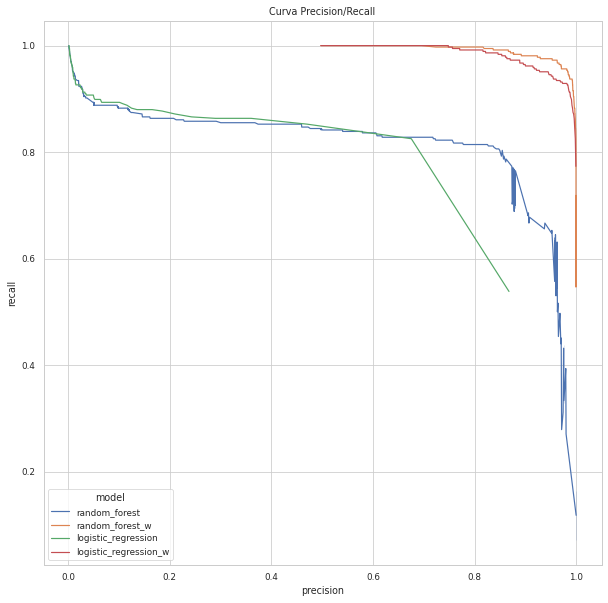

In [12]:
precision_recall_df = pd.DataFrame(columns=["precision", "recall", "model"])

for model_name, model in models_test_fit.items():
    precision_recall_df = evaluate_model_train(model_name, model, train_df, precision_recall_df)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
g = sns.lineplot(
    data=precision_recall_df,
    x="precision", y="recall", hue="model"
)
plt.title("Curva Precision/Recall")
plt.show()

In [13]:
best_model = models["random_forest_w"]
best_model_fit = models_test_fit["random_forest_w"]
(best_model, best_model_fit)

(Pipeline_9d507bf5be19, PipelineModel_4996917dad08)

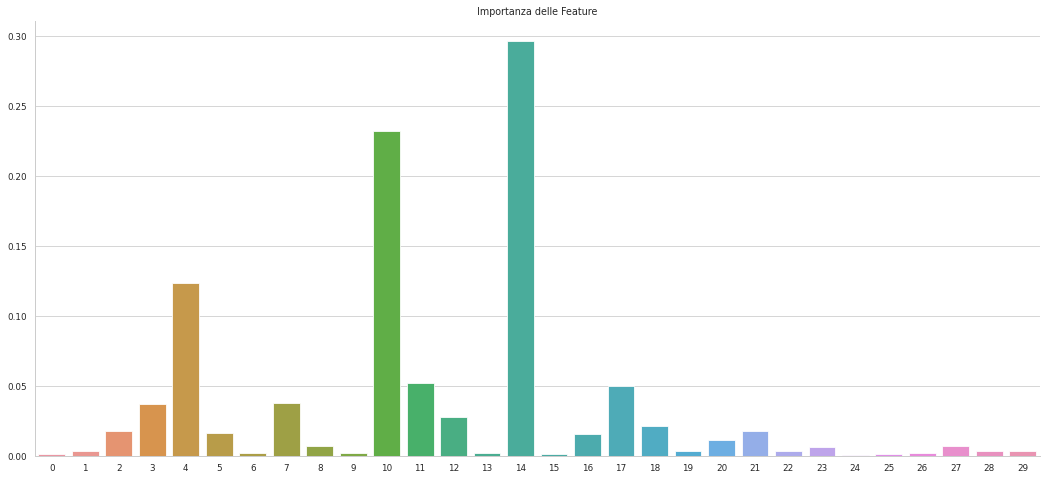

In [14]:
feature_importances = best_model_fit.stages[1].featureImportances.toArray()

fig, ax = plt.subplots(1, 1, figsize =(18,8))
g = sns.barplot(y=feature_importances, x=list(range(len(feature_importances))), ax=ax)
plt.title("Importanza delle Feature")
sns.despine()
plt.show()

## Feature selection

In [15]:
FEATURE_SEL_TRESHOLD = np.quantile(feature_importances, .5)
print(f"FEATURE_SEL_TRESHOLD: {FEATURE_SEL_TRESHOLD:02.2%}")

selected_features = [col for ix, col in enumerate(FEATURE_COL_NAMES) if feature_importances[ix] > FEATURE_SEL_TRESHOLD]
print(f"Feature selezionate ({len(selected_features)} sy {len(feature_importances)}): {selected_features}")

FEATURE_SEL_TRESHOLD: 0.69%
Feature selezionate (15 sy 30): ['V2', 'V3', 'V4', 'V5', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V20', 'V21', 'V27']


In [16]:
selector = UnivariateFeatureSelector(outputCol="SelectedFeatures", featuresCol="Features", labelCol="Class", selectionMode="fpr")\
    .setSelectionThreshold(.05)\
    .setFeatureType("continuous")\
    .setLabelType("categorical")
selector_model = selector.fit(best_model_fit.stages[0].transform(train_df))
selector_model

UnivariateFeatureSelectorModel: uid=UnivariateFeatureSelector_8d5ad814ca52, numSelectedFeatures=26

## Ottimizzazione con cross-validation

In [17]:
assembler = VectorAssembler(inputCols=FEATURE_COL_NAMES, outputCol="Features")
random_forest = RandomForestClassifier(featuresCol="SelectedFeatures", labelCol="Class", weightCol="Peso", seed=42)
pipeline = Pipeline().setStages([
    assembler,
    selector,
    random_forest,
])

In [18]:
paramGrid = ParamGridBuilder().addGrid(random_forest.maxBins,[15, 20, 25])\
                              .addGrid(random_forest.maxDepth,[4,6,8])\
                              .addGrid(random_forest.impurity,["entropy","gini"])\
                              .build()

In [19]:
evaluator = BinaryClassificationEvaluator(labelCol="Class", metricName="areaUnderPR")
cv = CrossValidator(seed=42).setEstimator(pipeline)\
                     .setEvaluator(evaluator)\
                     .setEstimatorParamMaps(paramGrid)\
                     .setNumFolds(10)

In [21]:
cvModel = cv.fit(train_df)

21/08/30 10:07:48 WARN CacheManager: Asked to cache already cached data.
21/08/30 10:07:48 WARN CacheManager: Asked to cache already cached data.


In [22]:
cvModel.bestModel.stages[-1]

RandomForestClassificationModel: uid=RandomForestClassifier_acf14f0b39b1, numTrees=20, numClasses=2, numFeatures=26

>>> MODELLO: CROSS-VALIDATED MODEL

    Precision/Recall:                   CLASSE
                                  |   0    |   1    | 
                        ----------|--------|--------|
                        precision | 94.38% | 99.95% |
                        ----------|--------|--------|
                        recall    | 99.95% | 93.99% |
                        ----------|--------|--------|
                        f1-score  | 97.09% | 96.88% |
                        -----------------------------

    Area Under PR Curve:  99.98%
    


Text(0.5, 1.0, 'Curva Precision/Recall')

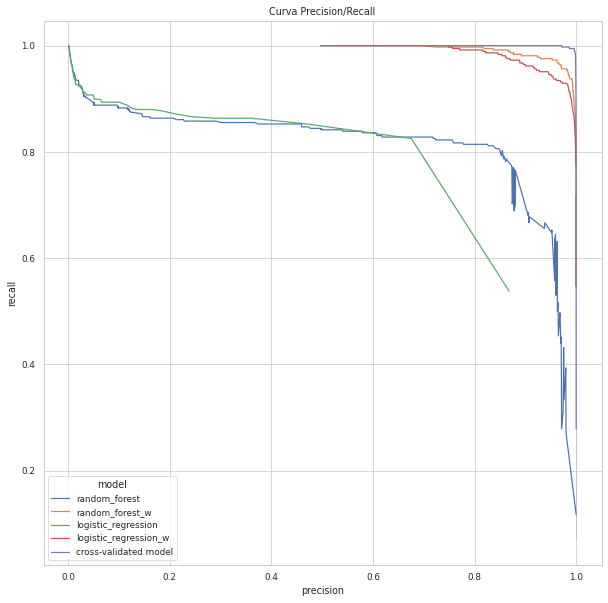

In [27]:
cv_precision_recall_df = evaluate_model_train("cross-validated model", cvModel.bestModel, train_df, precision_recall_df)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
g = sns.lineplot(
    data=cv_precision_recall_df,
    x="precision", y="recall", hue="model"
)
plt.title("Curva Precision/Recall")

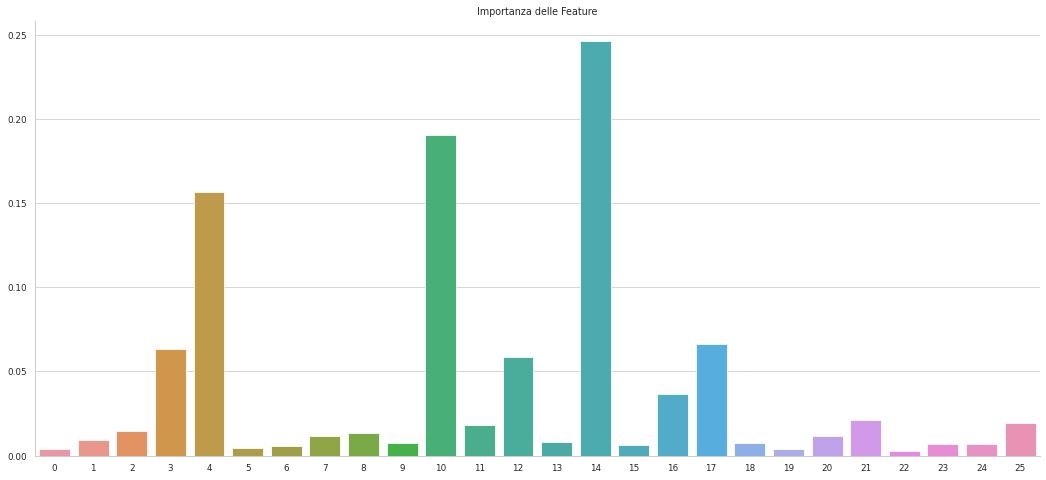

In [28]:
feature_importances = cvModel.bestModel.stages[-1].featureImportances.toArray()

fig, ax = plt.subplots(1, 1, figsize =(18,8))
g = sns.barplot(y=feature_importances, x=list(range(len(feature_importances))), ax=ax)
plt.title("Importanza delle Feature")
sns.despine()
plt.show()

## Valutazione sui dati Test

In [35]:
for model_name, model in models_test_fit.items():
    evaluate_model_test(model_name, model, test_df, evaluator)

evaluate_model_test("cross-validated model", cvModel.bestModel, test_df, evaluator)

>>> MODELLO: RANDOM_FOREST
    Area Under PR Curve:  81.07%
    
>>> MODELLO: RANDOM_FOREST_W
    Area Under PR Curve:  74.30%
    
>>> MODELLO: LOGISTIC_REGRESSION
    Area Under PR Curve:  73.99%
    
>>> MODELLO: LOGISTIC_REGRESSION_W
    Area Under PR Curve:  74.56%
    
>>> MODELLO: CROSS-VALIDATED MODEL
    Area Under PR Curve:  81.01%
    


La grande differenza tra l'AUPRC sul dataset di training e quello di test, nonchè la diminuzione della stessa a seguito del test, indicano dei principi di overfit per i modelli. Per questa ragione potrebbe essere ragionevole utilizzare dei criteri maggiormente rigorosi nella selezione delle feature (es. Selezione univariata - basata su ANOVA) o l'inserimento di pesi nell'evaluator 